In [1]:
from dependencies.NN import *
from dependencies.LTL import *
from dependencies.Utility_funcs import *

from dependencies.csrl.mdp import GridMDP
from dependencies.csrl.oa import OmegaAutomaton
from dependencies.csrl import ControlSynthesis
import numpy as np
import os

from matplotlib import pyplot as plt
import time 

2024-01-27 11:51:13.449057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of Omega-automaton states (including the trap state): 6


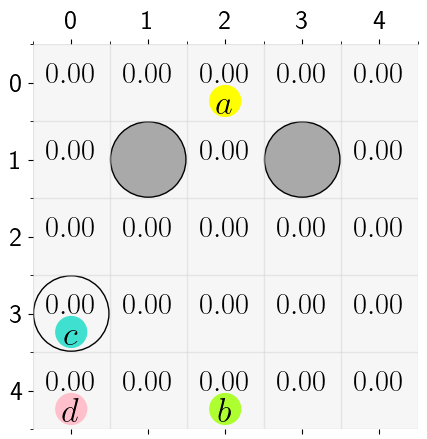

In [5]:
ltl = ("(G !d) & ((!c) U b) & ((!b) U a) & (F G c)")

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,5)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E',  'E'],
['E',  'B',  'E',  'B',  'E'],
['E',  'E',  'E',  'E',  'E'],
['T',  'E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    ('a',),    (),    ()],
[(),    (),    (),(),    ()],
[(),    (),    (),    (),    ()],
[('c',),(),    (),(),()],
[('d',),    (),    ('b',),(),    ()]
],dtype=object)
# Colors of the labels 
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
}

p = 1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot(save="env.pdf")

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

s_vectors = state_vectors(csrl)
enc = list(np.unique(grid_mdp.label))
enc.pop(enc.index(()))
ch_states = channeled(csrl, enc)
total_number_of_states = csrl.mdp.shape[0]*csrl.mdp.shape[1]*csrl.oa.shape[1]

In [3]:
t = "[] ~d /\ (~c % b) /\ (~b % a) /\ (<> [] c)"

LTL_formula = parser.parse(t)
predicates=get_predicates(grid_mdp)
print(predicates)

{'a': [2], 'b': [22], 'c': [15], 'd': [20]}


In [4]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
# model.summary()

2024-01-27 11:51:52.508656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 11:51:52.510542: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [50]:
model.load_weights(f'outputs/models/seq_del_p{p}')

In [59]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10
NN_value_active = False

search_depth = 100
MCTS_samples = 100

num_training_epochs =  0
num_test_epochs = 100
training = True
epochs = 10
C = 0.5
# C= 0.01
tow = 0.1
T = [35]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []
best_val_len = {}
for s in csrl.states(): best_val_len[s] = (0.001, 99999)

if os.path.exists("outputs/Log_run.txt"): os.remove("outputs/Log_run.txt")
for i in T:
    idx += 1
    print("##########################")
    print("C:",C, "| tow:",tow)
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        print(N[(0, 0, 4, 3)][:4])
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy, best_val_len = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=C, tow=tow, n_samples=MCTS_samples, visited=visited_train,
                start=None, search_depth=search_depth, verbose=0, T=i, K=K, NN_value_active=NN_value_active, run_num=epoch, ltl_f_rew=True, reachability=True,
                best_val_len = best_val_len)
        
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0:
            train_wins+=1
            NN_value_active = True

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        print(N[(0, 0, 4, 3)][:4])
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy, best_val_len = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=0.1, tow=0.05, n_samples=MCTS_samples, visited=visited_test,
                start=None, search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True, run_num=epoch, ltl_f_rew=True,
                reachability=True, best_val_len = best_val_len)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]
Q1, N1, W1, P1 = Q, N, W, P
# u, d, r, l

##########################
C: 0.5 | tow: 0.1
[0. 0. 0. 0.]
0 ) MCTS conf: -0.12 , det: 1.0 | LTL [+++]  LDBA [ 0.0 ] path: [11, 10, 5, 0, 1, 2, 1, 1, 2, 3, 4, 9, 14, 19, 24, 23, 22, 23, 23, 24, 19, 14, 13, 12, 11, 11, 10, 15]
[0. 0. 0. 0.]
1 ) MCTS conf: -0.12 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [12, 7]
[0. 0. 0. 0.]
2 ) MCTS conf: -0.0 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [13, 14, 9, 4, 3, 2, 1, 2, 2, 7]
[0. 0. 0. 0.]
3 ) MCTS conf: -0.05 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [24, 19, 14, 9, 4, 3, 2, 7]
[7. 7. 1. 1.]
4 ) MCTS conf: 0.04 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [5, 0, 1, 2, 1, 1, 2, 2, 3, 4, 4, 4, 9, 14, 13, 14, 19, 24, 23, 22, 23, 24, 19, 14, 13, 18]
[7. 7. 1. 1.]
5 ) MCTS conf: 0.19 , det: 1.0 | LTL [+++]  LDBA [ 0.0 ] path: [1, 2, 1, 2, 3, 4, 4, 9, 14, 19, 24, 23, 22, 23, 24, 19, 14, 13, 12, 11, 11, 10, 15]
[7. 7. 1. 1.]
6 ) MCTS conf: -0.08 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [10, 5, 5, 0, 1, 2, 1, 2, 3, 4, 9, 14, 19, 24, 23, 18]
[7. 7. 1

In [7]:
N1[(0,0,4,2)]

array([7.000e+00, 1.000e+00, 3.000e+01, 1.352e+03, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

In [52]:
f'outputs\models\seq_del_p{p}'

'outputs\\models\\seq_del_p0.9'

In [60]:
model.save_weights(f'outputs/models/seq_del_p{p}')

In [5]:
N1 = np.load(f'outputs/Ours/SD_{p}.npy')

In [8]:
N[(0,1,2,0)]

array([598., 769.,   5.,   9.,   0.,   0., 597.,   0.,   0.,   0.])

In [18]:
Q[(0, 0, 4, 3)]

array([-0.5       , -0.49993477, -0.5       , -0.5       ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [61]:
policy2=np.argmax(N1,axis=4)
value2=np.max(N1,axis=4)
np.save(f'outputs/Ours/New_{p}', N1)

In [62]:
episodes, rew = run_Q_test(csrl, policy2, LTL_formula, predicates, start=None, T=35, runs=1000, verbose=0, reachability=True)

Running 1000 simulations with 35 time-steps...
Test finished with:
	success rate: 414 / 1000 = 0.414


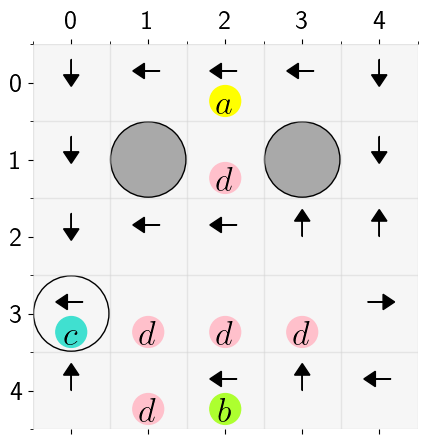

In [77]:
grid_mdp.plot(policy=policy2[0, 5])

In [13]:
csrl.mdp.label[3,0]

('c',)

In [28]:
(W[state])/N[state]

/tmp/ipykernel_13239/3964365869.py:1: RuntimeWarning: invalid value encountered in divide
  (W[state])/N[state]


array([-0.5      , -0.5      , -0.5      , -0.4983165,        nan,
              nan,        nan,        nan,        nan,        nan])

In [26]:
state = (0, 0, 4, 3)
print([round(i,2) for i in Q[state][:6]])
print([round(i,2) for i in W[state][:6]])
print([round(i,2) for i in N1[state][:8]])
csrl.transition_probs[(state)][2]

[-0.5, -0.5, -0.5, -0.5, 0.0, 0.0]
[-1.5, -16.5, -8.5, -444.0, 0.0, 0.0]
[3.0, 33.0, 17.0, 891.0, 0.0, 0.0, 0.0, 0.0]


([(0, 0, 3, 3), (0, 0, 4, 4)], [0.0, 1])

In [ ]:
# u, d, r, l

0.8170728068875467

In [6]:
Q =csrl.q_learning(T=100,K=10000)
np.save(f'outputs/CSRL/New_{p}', Q)

In [8]:
policy1=np.argmax(Q,axis=4)
value1=np.max(Q,axis=4)

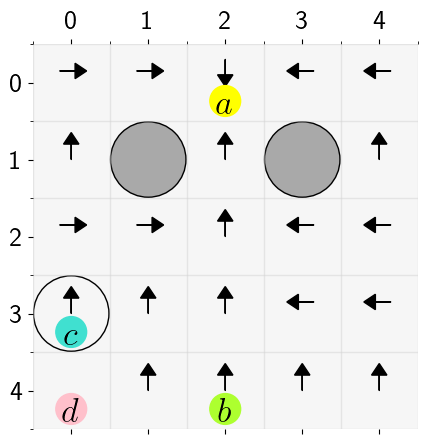

In [14]:
grid_mdp.plot(policy=policy1[0, 0])

In [9]:
episodes, rew = run_Q_test(csrl, policy1, LTL_formula, predicates, start=None, T=100, runs=1000, verbose=0, reachability=True)

Running 1000 simulations with 100 time-steps...
Test finished with:
	success rate: 1000 / 1000 = 1.0


In [ ]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10

search_depth = 30
MCTS_samples = 100

num_training_epochs =  30
num_test_epochs = 10
training = True
epochs = 10
T = [25]
K = 1
batch_size = 32
steps_per_epoch = 4

success_rates = []
succes_std = []
win_hist = []
train_history = []

os.remove("Log_run.txt")
for i in T:
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        print(Q[(0,0,0,0)][:4], len(visited_train))
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=0.5, tow=1, n_samples=MCTS_samples, visited=visited_train,
                start=(0,0), search_depth=search_depth, verbose=0, T=i, K=K, run_num=epoch, ltl_f_rew=False)
        
        # print('N',N[(0,0,4,1)][:5])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0: train_wins+=1

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=1, tow=1, n_samples=MCTS_samples, visited=visited_test,
                start=(0,0), search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]

[0. 0. 0. 0.] 0
0 ) MCTS conf: -27.0 , det: 1.0 | 

c:\Users\pc-admin\OneDrive - University of Waterloo\MSc\research\Code\RL-LTL\ComputeCanada_scrips\Utility_funcs.py:300: RuntimeWarning: overflow encountered in power
  Pi = (N[root]**(1/tow)) / np.sum(N[root]**(1/tow))
c:\Users\pc-admin\OneDrive - University of Waterloo\MSc\research\Code\RL-LTL\ComputeCanada_scrips\Utility_funcs.py:300: RuntimeWarning: invalid value encountered in divide
  Pi = (N[root]**(1/tow)) / np.sum(N[root]**(1/tow))


Warning
Pi: [ 0.  0.  0. nan  0.  0.  0.  0.  0.  0.]
N[root]: [7.000e+00 1.000e+00 4.000e+00 1.239e+03 0.000e+00 0.000e+00 6.000e+00
 0.000e+00 0.000e+00 0.000e+00]
root: (0, 1, 2, 1)
depth: -11
trajectory [0, 1, 2, 3, 4, 9, 14, 19, 24, 23, 22, 23, 24, 19, 14, 13, 12] + 11


ValueError: probabilities contain NaN

exploration in training: 0.35
exploration in testing: 0.18


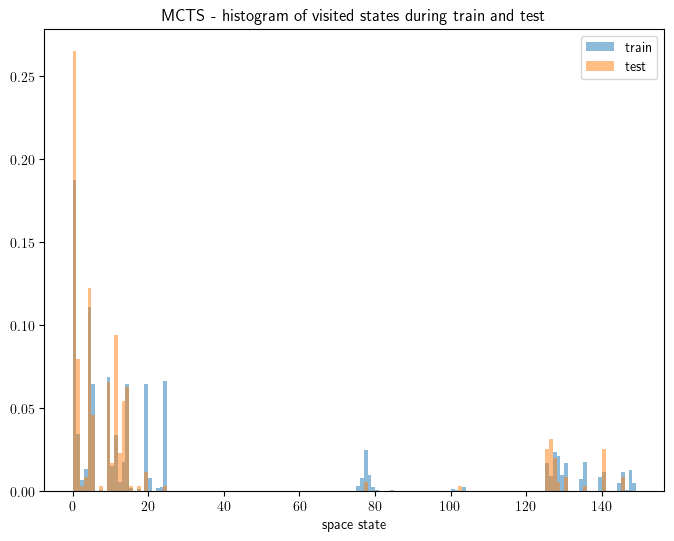

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(encode_visited_states_train, bins=range(total_number_of_states), density=True, alpha=0.5, label="train")
plt.title("MCTS - histogram of visited states during train and test")
plt.xlabel("space state")

plt.hist(encode_visited_states_test, bins=range(total_number_of_states), density=True, alpha=0.5, label="test")
plt.legend()

print("exploration in training:", round(np.unique(encode_visited_states_train).shape[0]/total_number_of_states, 2))
print("exploration in testing:", round(np.unique(encode_visited_states_test).shape[0]/total_number_of_states, 2))

ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

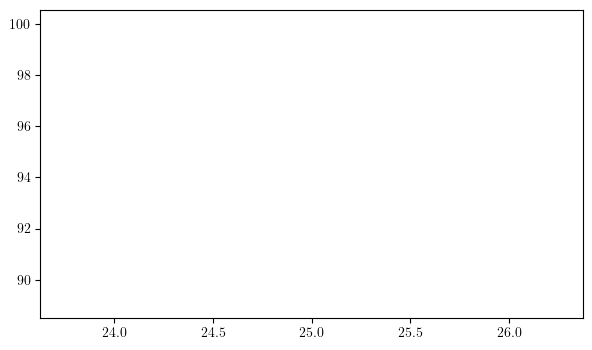

In [8]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel(f"succes rate (out of {num_test_epochs} runs)")
plt.title("MCTS performance results on the custom gridworld, P="+str(p))
success_rates

Text(0.5, 1.0, 'training loss')

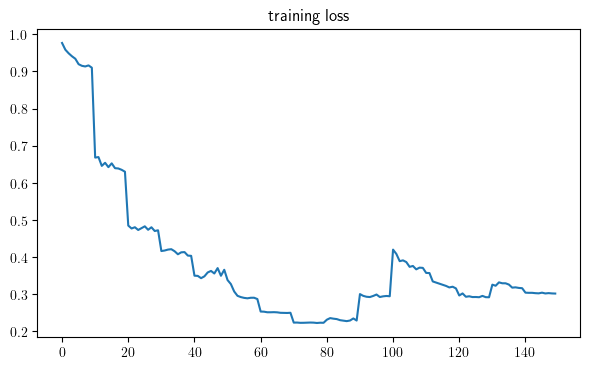

In [ ]:
interval = 400
plt.figure(figsize=(7,4))
plt.plot(train_history)
plt.title("training loss")
# plt.xticks(range(1,num_training_epochs*epochs,interval), range(0,num_training_epochs,interval//epochs));

In [5]:
Q, visited_states =csrl.q_learning(T=100,K=10000)
np.save(f'outputs/CSRL/SD_{p}', Q)

In [16]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

In [17]:
rewards_mean = []
rewards_std = []
n_runs = 100

T = [26, 50, 75, 100, 150, 200, 300, 400]

for i in T:
    episodes, rew = run_Q_test(csrl, policy, LTL_formula, predicates, T=i, start=(0,0), runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 100 simulations with 26 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 50 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 75 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 100 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 150 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 200 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 300 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 400 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0


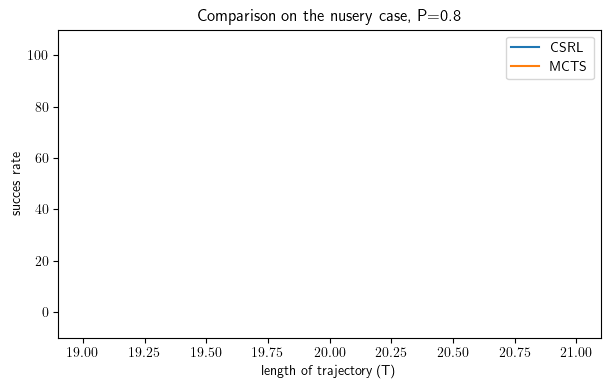

In [ ]:
plt.figure(figsize=(7,4))

plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the sequentil delivery case, P="+str(p))
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="RL-LTL")
plt.legend()